In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from joblib import dump, load
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso

import tensorflow as tf
from TransformationPipeline import TransformationPipeline
import warnings
warnings.filterwarnings('ignore')

### **1. Loading Data**

In [248]:
df = pd.read_csv('laptopPrice.csv')

In [249]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [250]:
print(df.shape)

(823, 19)


### **2. Data Checks**
- Checking missing values
- Checking duplicates
- Checking data types of each column
- Checking the number of unique values of each column
- Checking statistics of data set
- Checking various categories present in different categorical column

In [251]:
df.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

In [252]:
df.duplicated().sum()

21

In [253]:
df = df.drop_duplicates()

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 0 to 822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              802 non-null    object
 1   processor_brand    802 non-null    object
 2   processor_name     802 non-null    object
 3   processor_gnrtn    802 non-null    object
 4   ram_gb             802 non-null    object
 5   ram_type           802 non-null    object
 6   ssd                802 non-null    object
 7   hdd                802 non-null    object
 8   os                 802 non-null    object
 9   os_bit             802 non-null    object
 10  graphic_card_gb    802 non-null    object
 11  weight             802 non-null    object
 12  warranty           802 non-null    object
 13  Touchscreen        802 non-null    object
 14  msoffice           802 non-null    object
 15  Price              802 non-null    int64 
 16  rating             802 non-null    object
 17  Nu

In [255]:
df.nunique()

brand                  8
processor_brand        3
processor_name        11
processor_gnrtn        8
ram_gb                 4
ram_type               6
ssd                    7
hdd                    4
os                     3
os_bit                 2
graphic_card_gb        5
weight                 3
warranty               4
Touchscreen            2
msoffice               2
Price                405
rating                 5
Number of Ratings    282
Number of Reviews    135
dtype: int64

In [256]:
df.describe()

,Price,Number of Ratings,Number of Reviews
count,802.000000,802.00000,802.000000
mean,76625.543641,299.84414,36.089776
std,45232.984422,1001.78442,118.313553
min,16990.000000,0.00000,0.000000
25%,45990.000000,0.00000,0.000000
50%,63990.000000,17.00000,2.000000
75%,89525.000000,140.25000,18.000000
max,441990.000000,15279.00000,1947.000000


#### **Insights**
- There are some outliers in all the 3 numerical columns
- No missing values in the dataset

In [257]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object']
cat_features = [feature for feature in df.columns if df[feature].dtype == 'object']
print("Numerical features: ", numeric_features)
print("Categorical featues:", cat_features)

Numerical features:  ['Price', 'Number of Ratings', 'Number of Reviews']
Categorical featues: ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb', 'weight', 'warranty', 'Touchscreen', 'msoffice', 'rating']


### **3. Data Visualization**

#### 3.1 Histograms

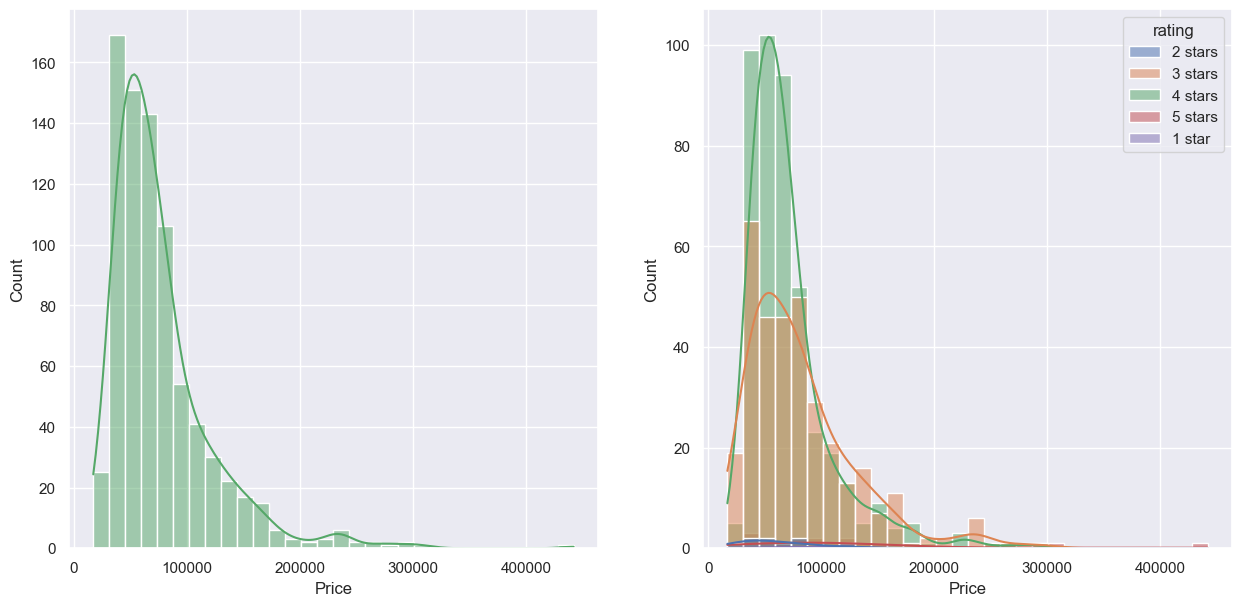

In [258]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g', hue= 'rating')
plt.show()

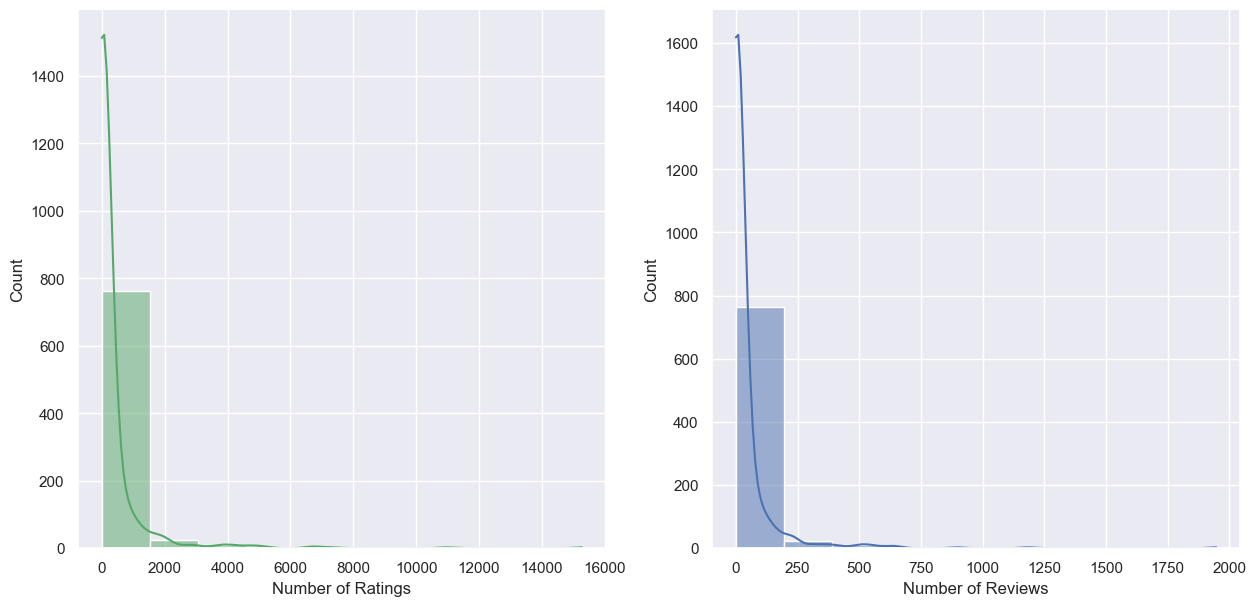

In [259]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='Number of Ratings',bins=10,kde=True,color='g')
plt.subplot(122)
sns.histplot(data=df,x='Number of Reviews',kde=True, bins = 10)
plt.show()

In [260]:
def remove_outliers(df, column):
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    iqr = percentile75-percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df


In [261]:
df = remove_outliers(df, 'Price')
df = remove_outliers(df, 'Number of Ratings')
df = remove_outliers(df, 'Number of Reviews')

#### 3.3 Multivariate Analysis

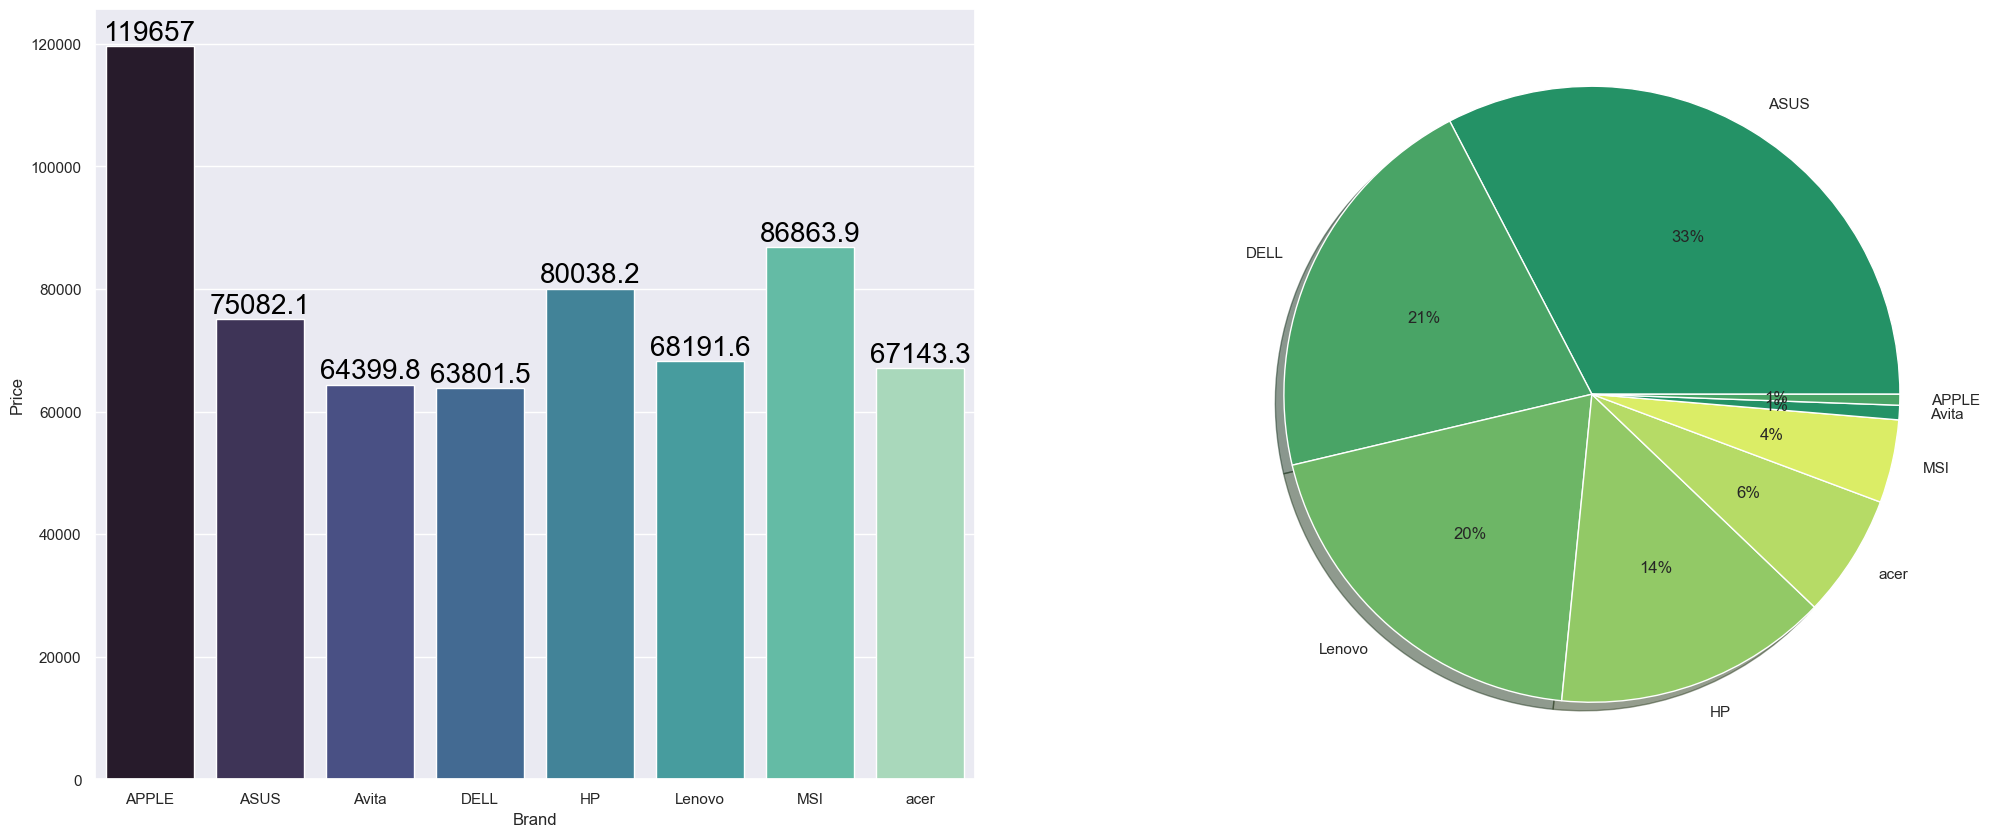

In [262]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Brand")
    ax[0].set_ylabel("Price")
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['brand'].value_counts(),labels=df['brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

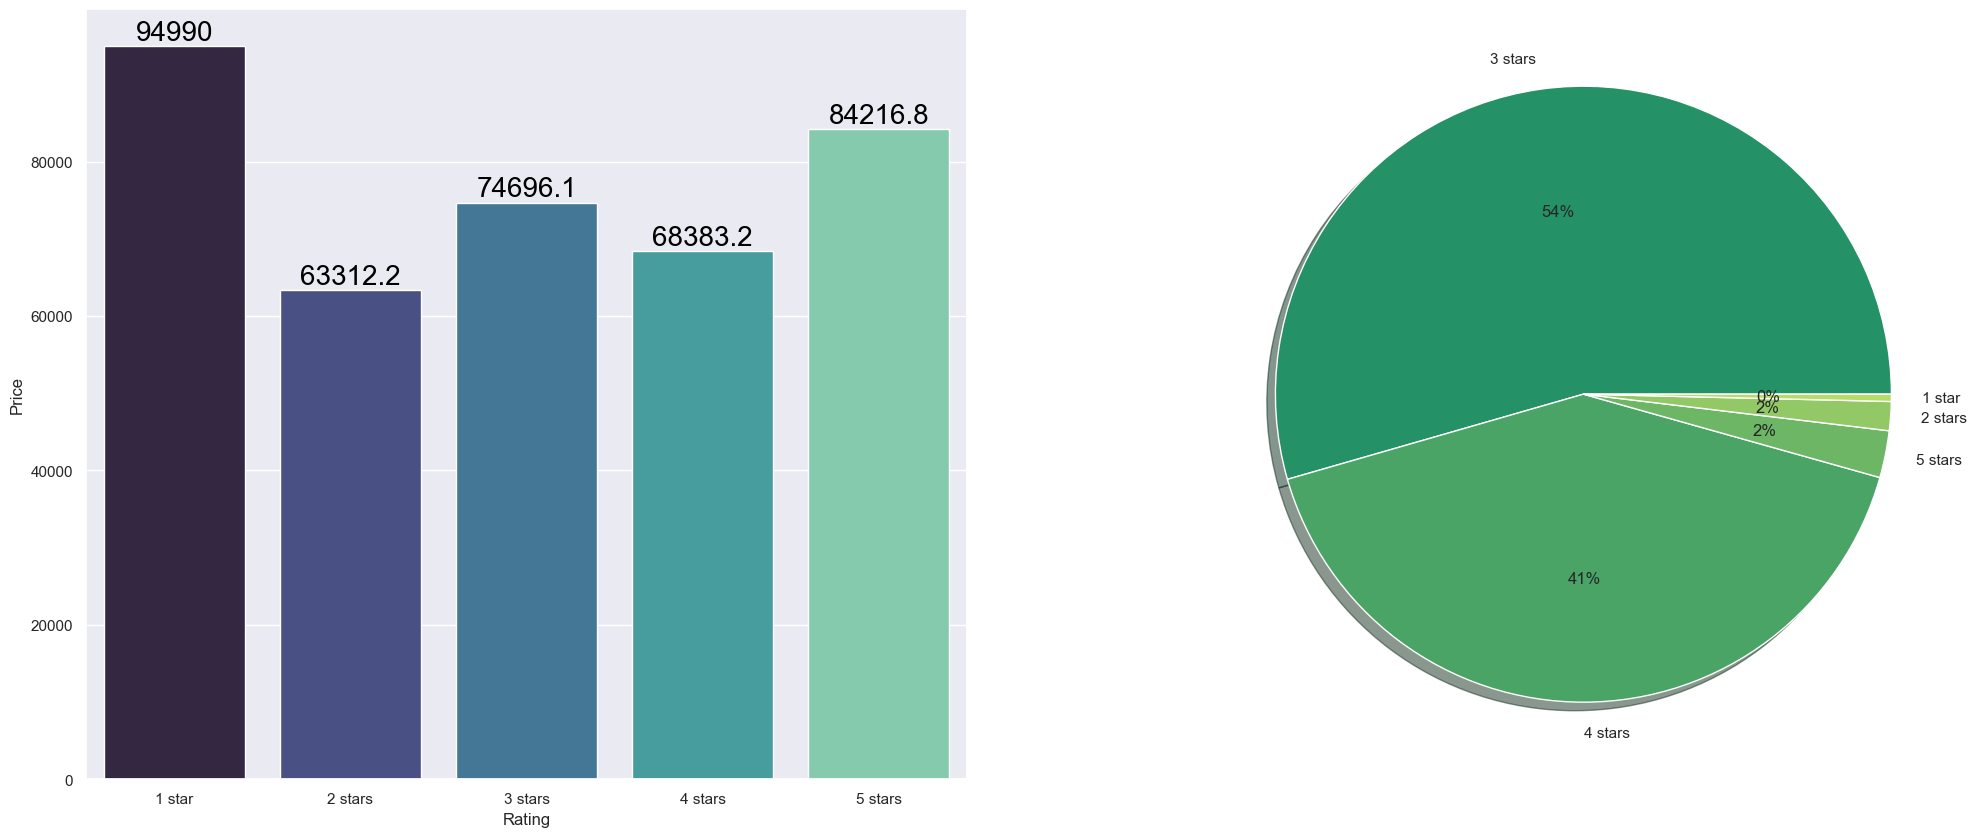

In [263]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('rating')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Rating")
    ax[0].set_ylabel("Price")
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['rating'].value_counts(),labels=df['rating'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

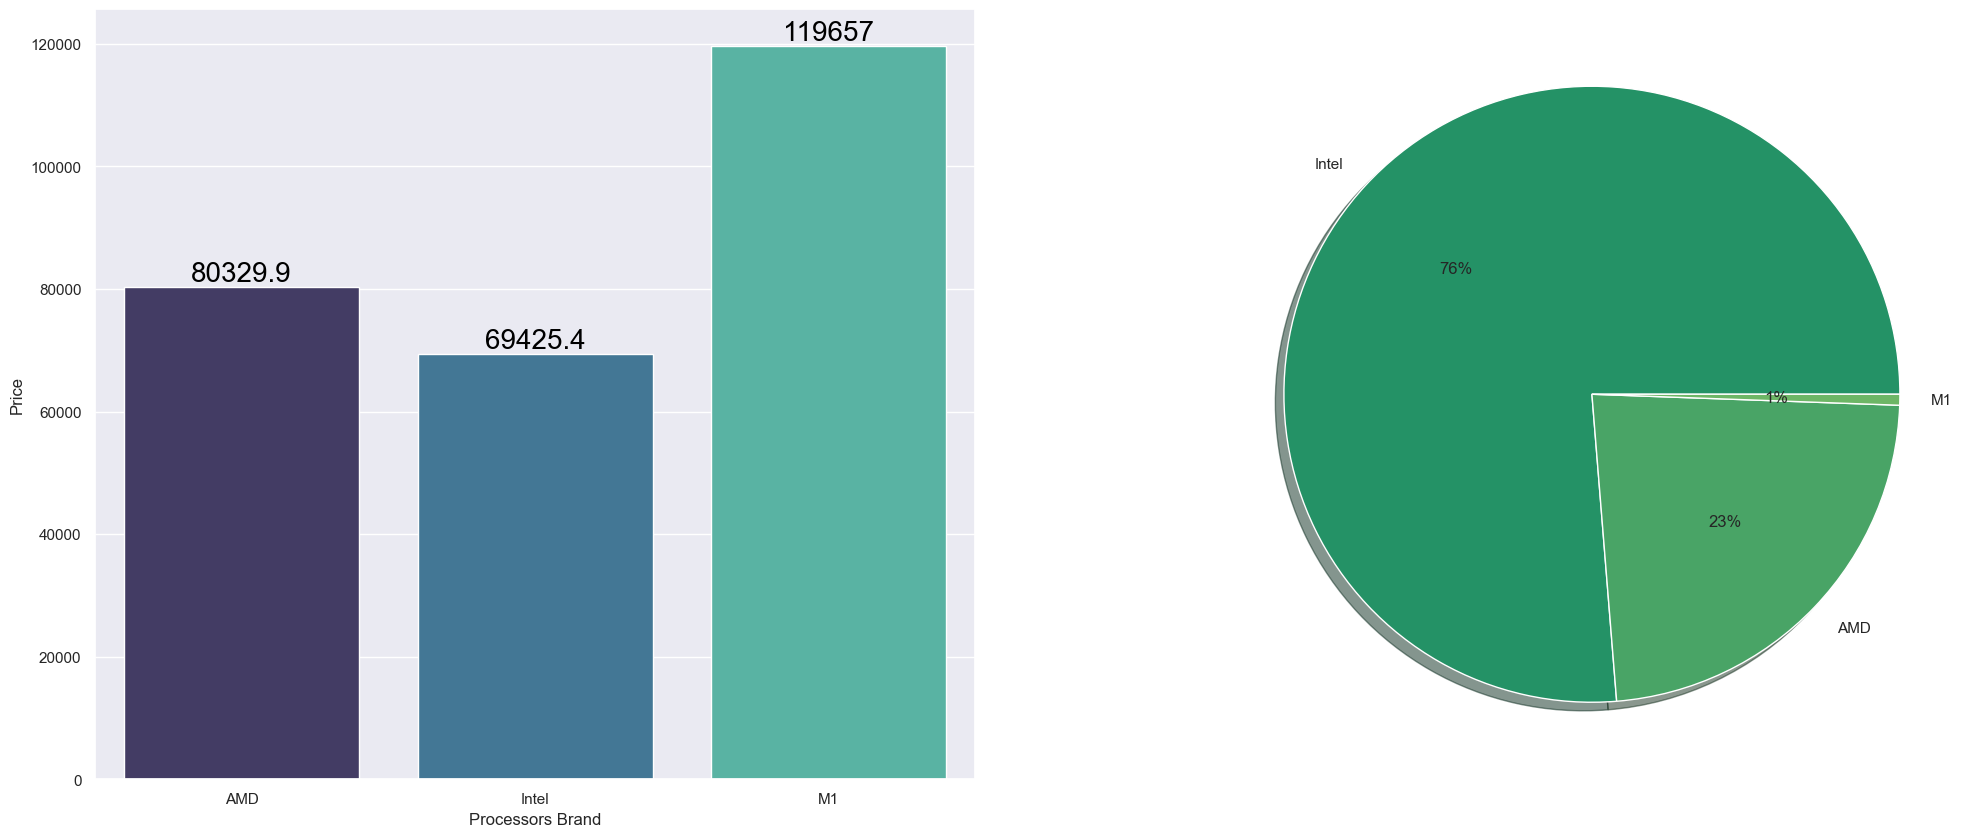

In [264]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('processor_brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Processors Brand")
    ax[0].set_ylabel("Price")
    
palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_brand'].value_counts(),labels=df['processor_brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

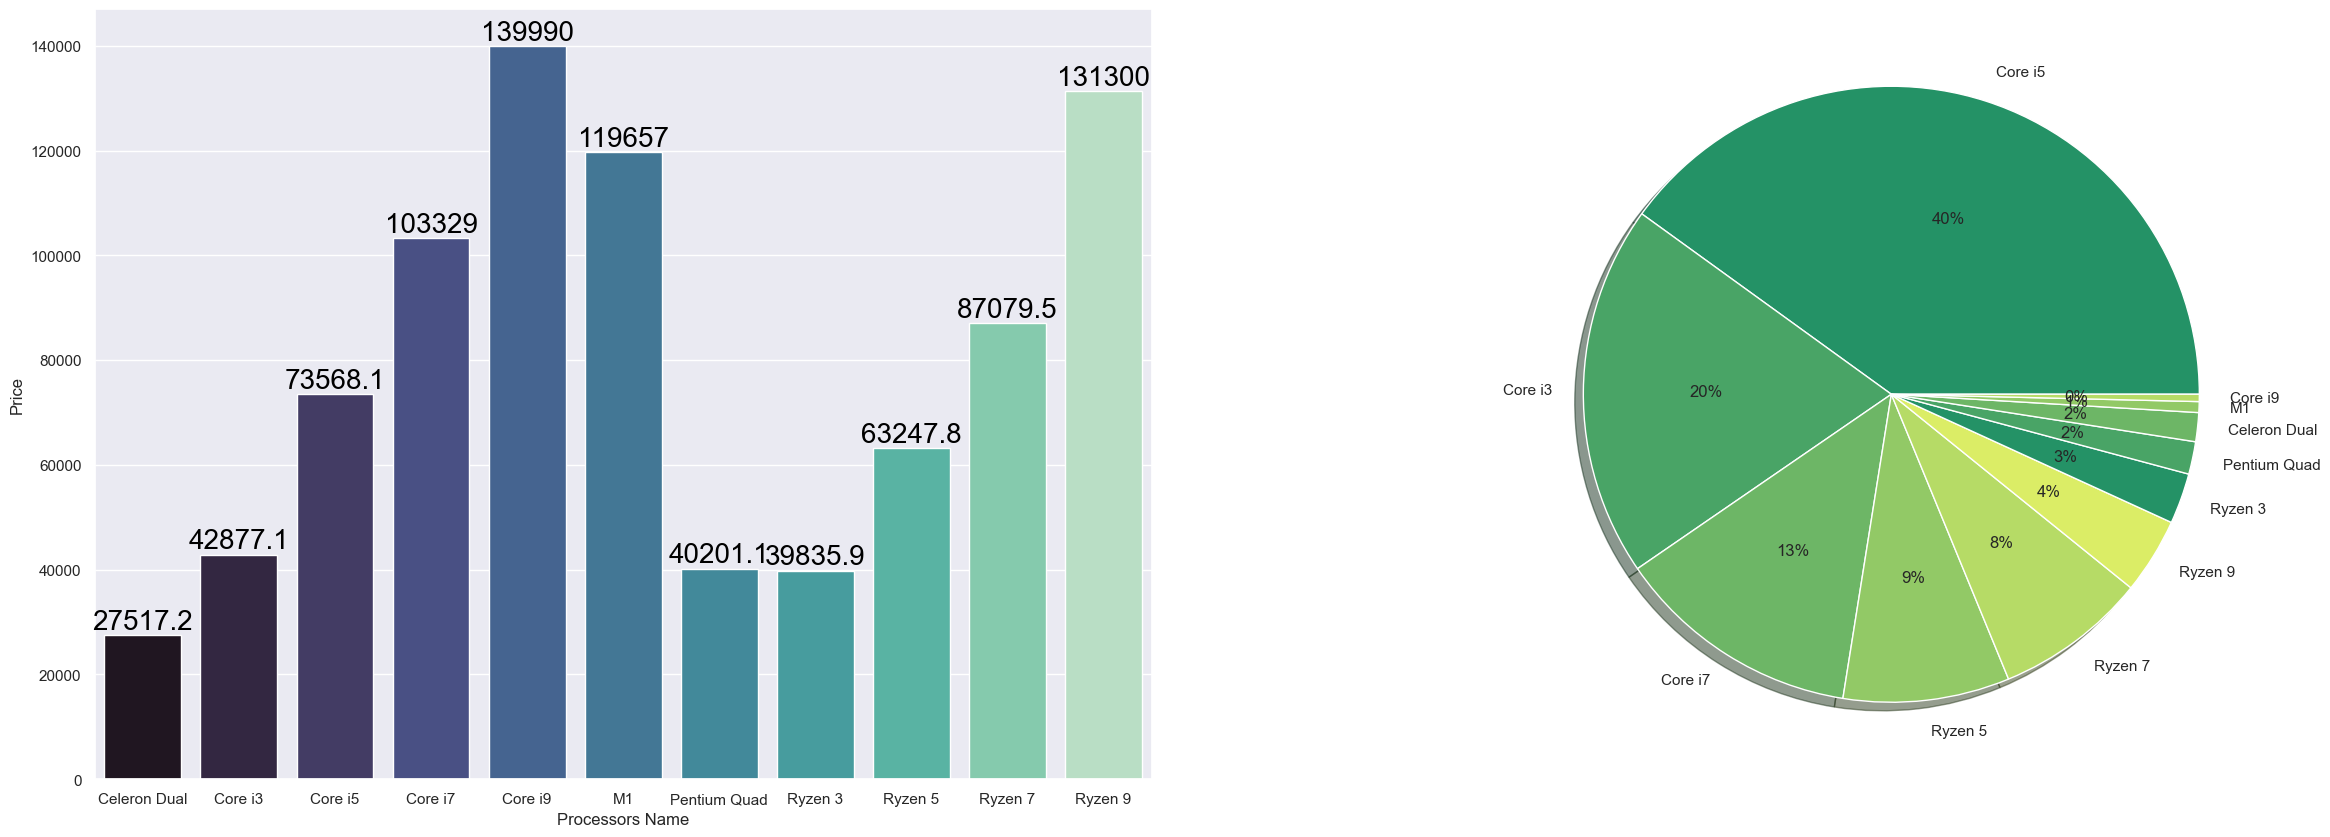

In [265]:
f,ax=plt.subplots(1,2,figsize=(30,10))
Group_data = df.groupby('processor_name')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Processors Name")
    ax[0].set_ylabel("Price")
palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_name'].value_counts(),labels=df['processor_name'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

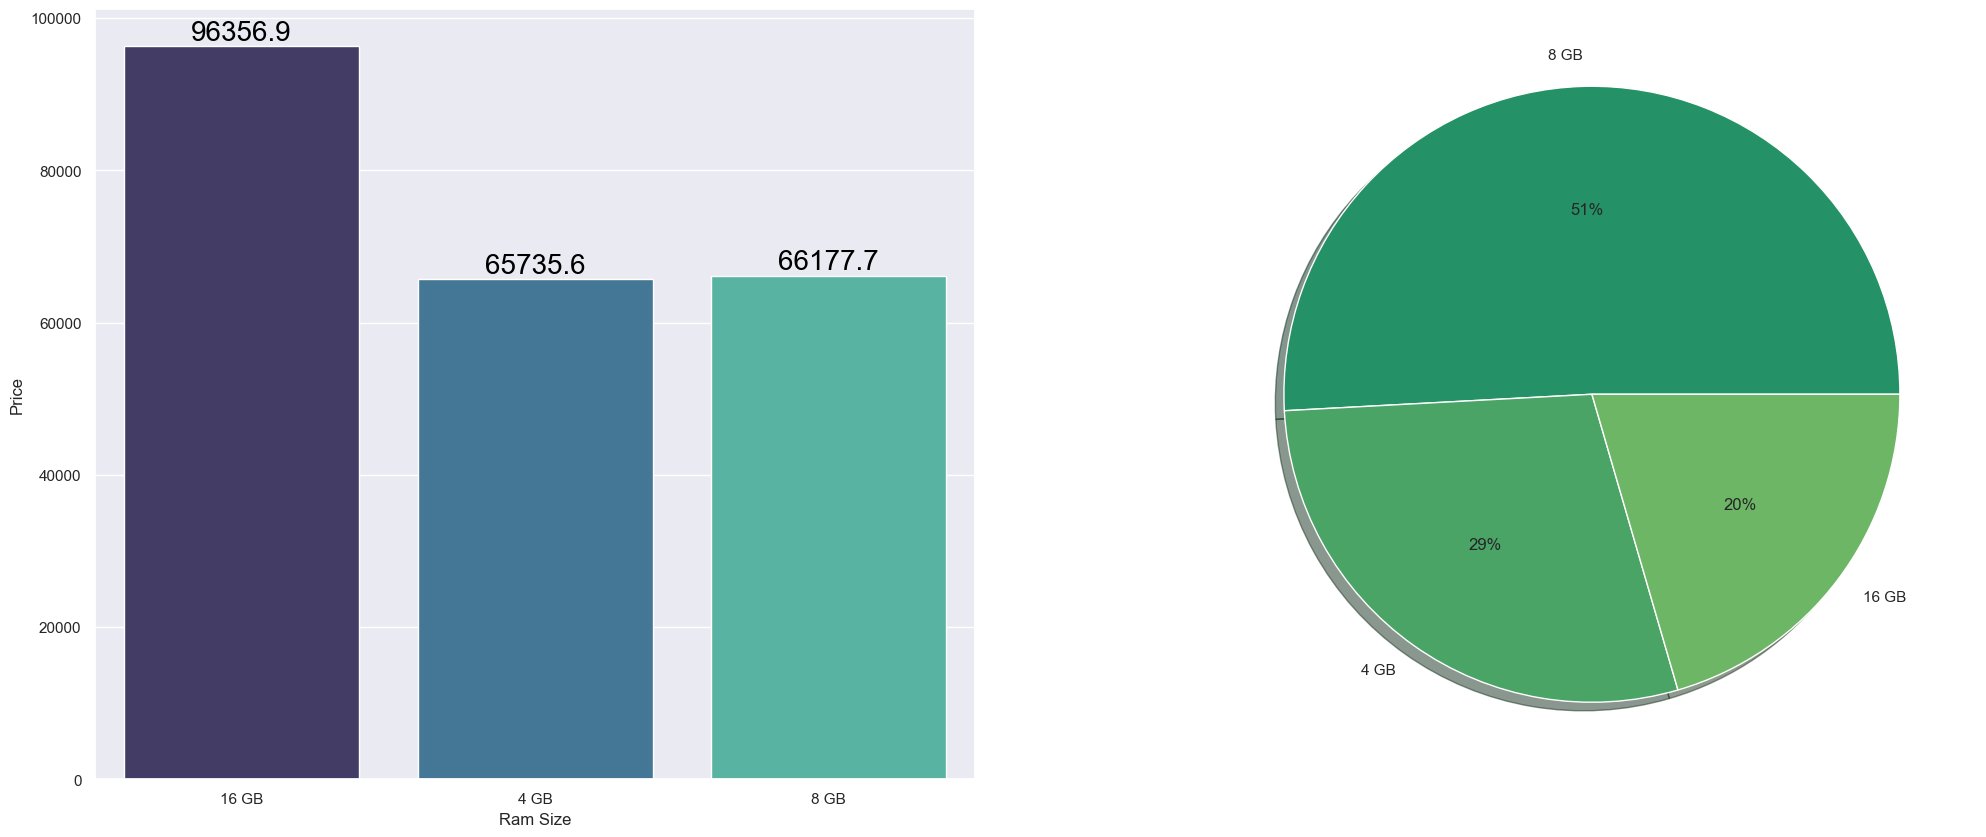

In [266]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('ram_gb')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Ram Size")
    ax[0].set_ylabel("Price")
palette_color = sns.color_palette('summer')
plt.pie(x = df['ram_gb'].value_counts(),labels=df['ram_gb'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

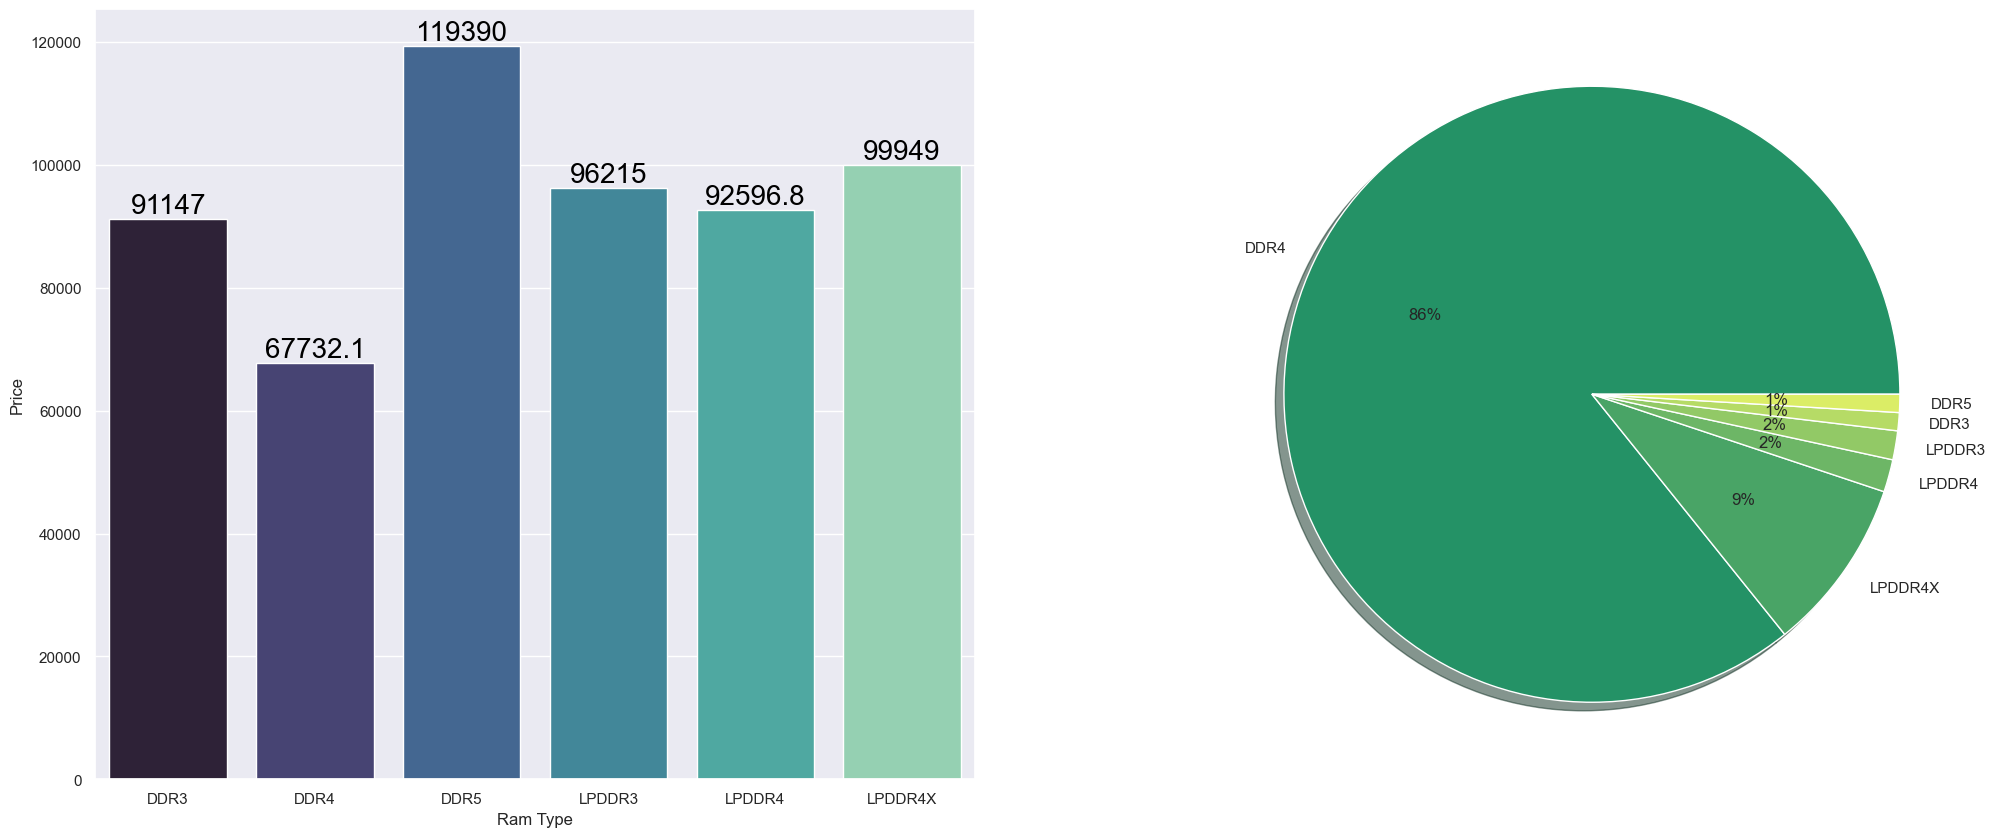

In [267]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('ram_type')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Ram Type")
    ax[0].set_ylabel("Price")
palette_color = sns.color_palette('summer')
plt.pie(x = df['ram_type'].value_counts(),labels=df['ram_type'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

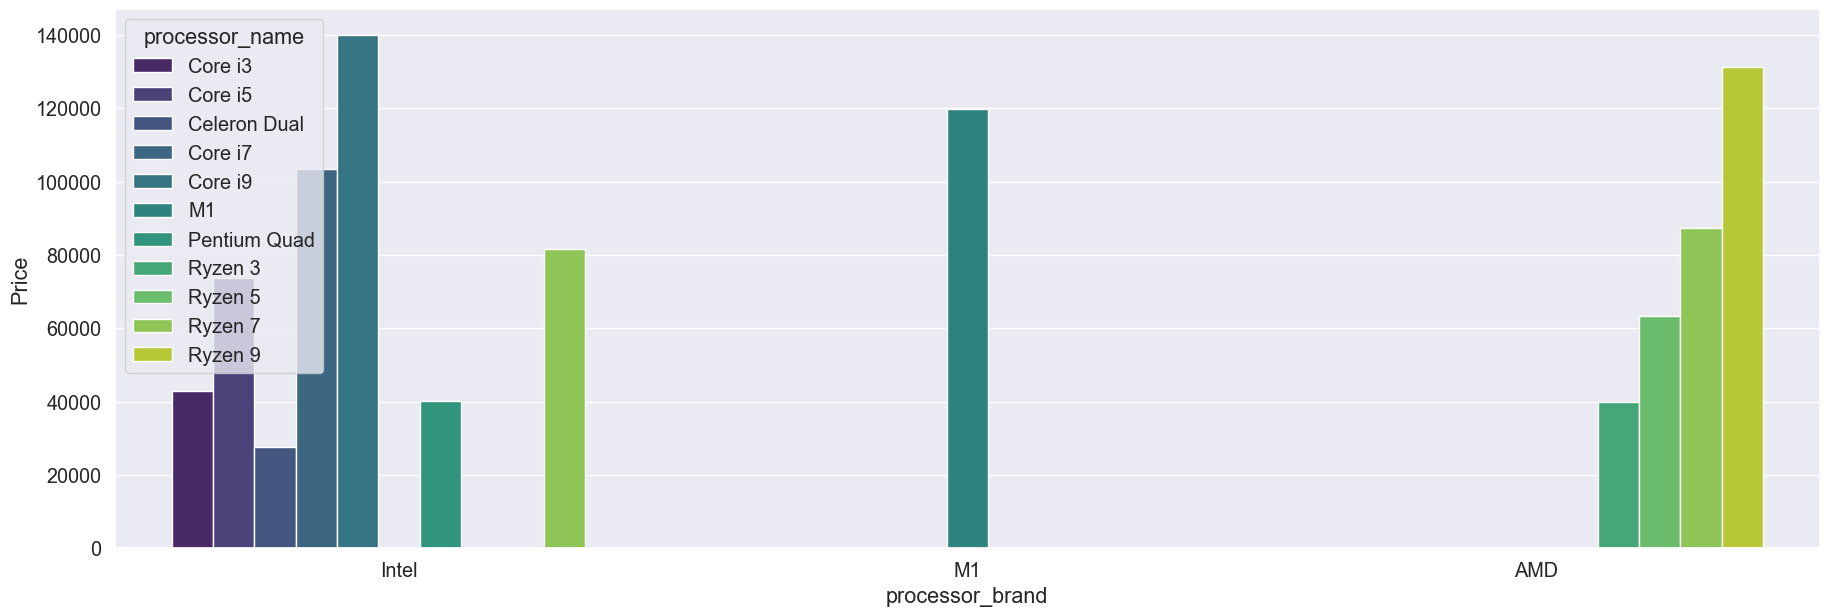

In [268]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['processor_brand'], 
                 y=df['Price'],
                 hue = df['processor_name'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Price');

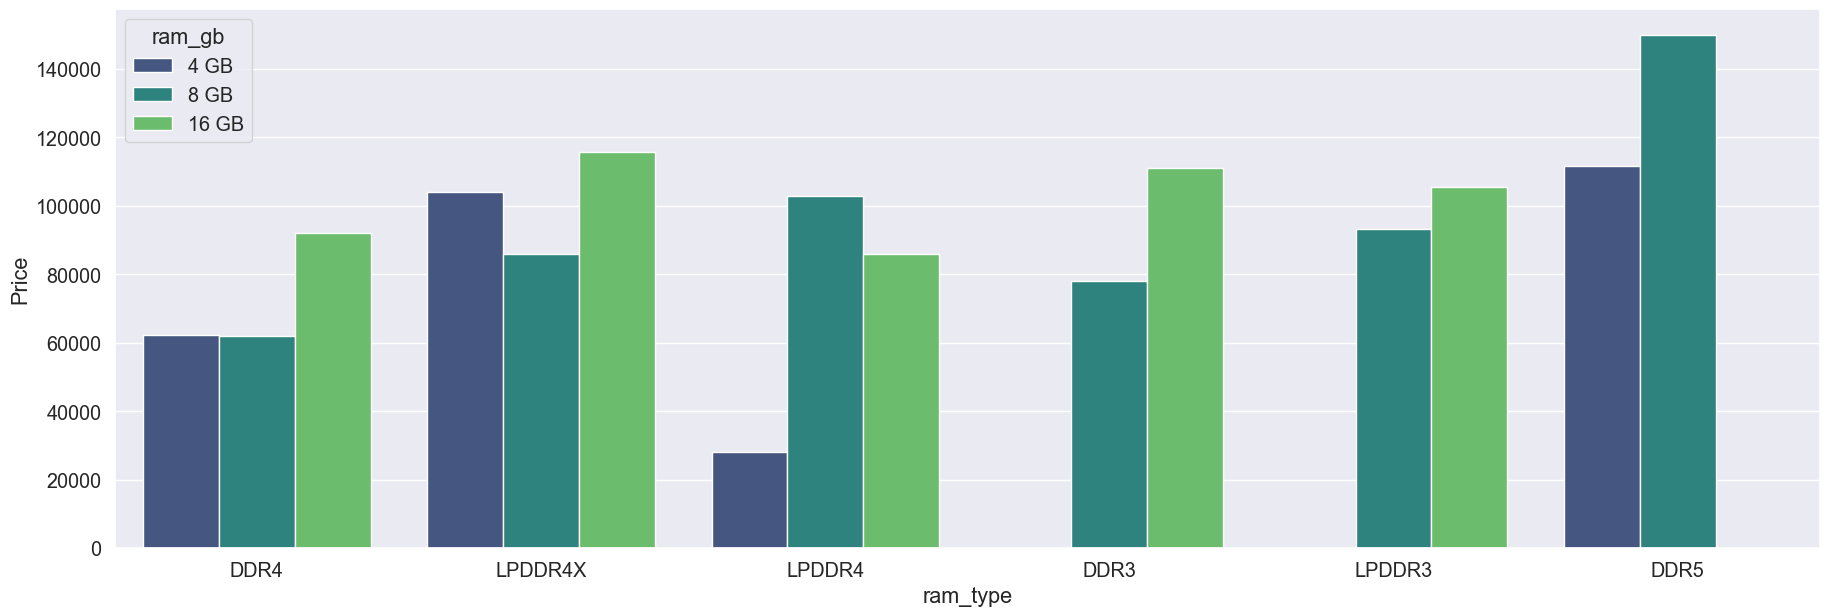

In [269]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['ram_type'], 
                 y=df['Price'],
                 hue = df['ram_gb'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Price');

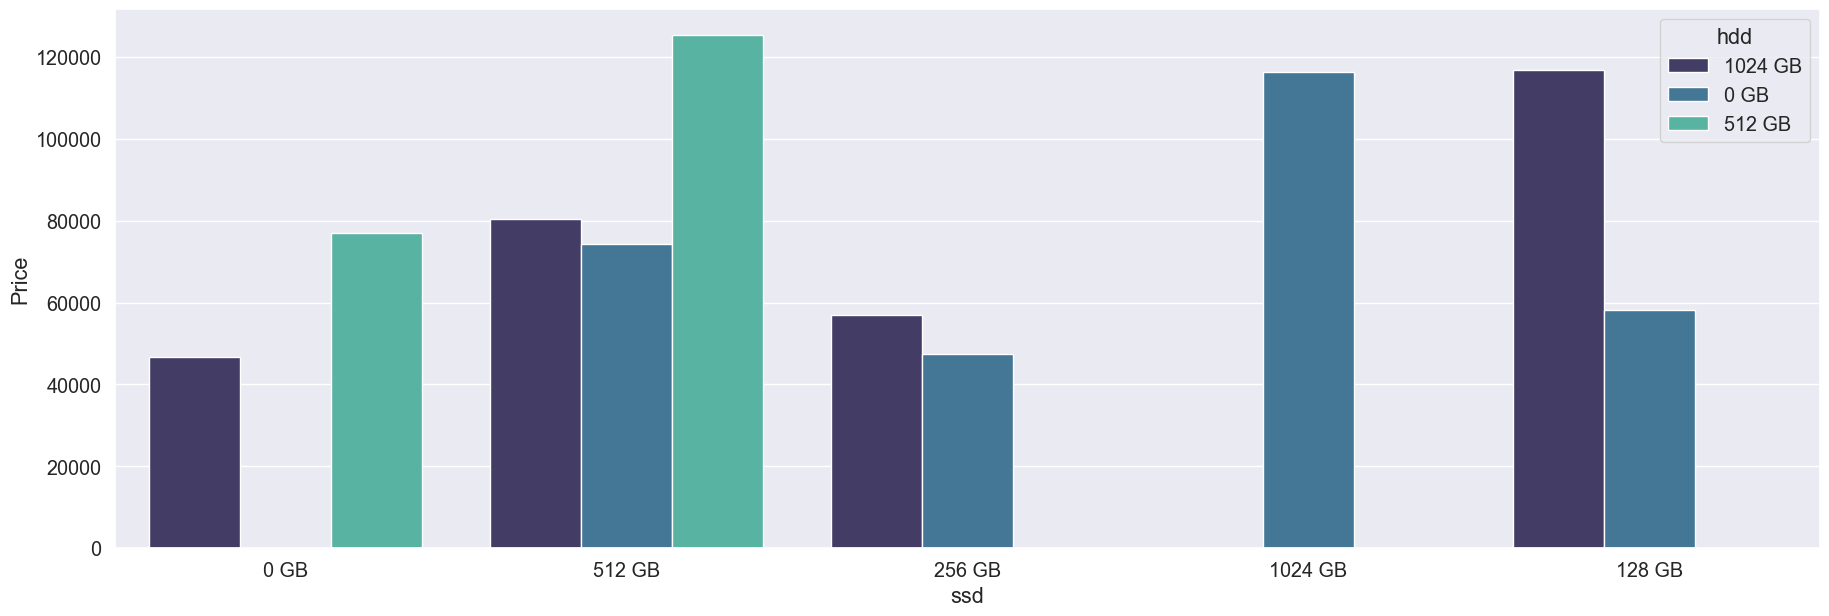

In [270]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['ssd'], 
                 y=df['Price'],
                 hue = df['hdd'], 
                 palette='mako',
                 ci = None)
plt.ylabel('Price');

### **4. Transformation Pipeline**

In [271]:
X = df.drop('Price', axis = 1)
y = df.Price

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state= 1)
X_train.shape, X_test.shape

((474, 18), (53, 18))

In [273]:
preprocessor = TransformationPipeline().preprocess(d=df)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [274]:
dump(preprocessor,"preprocessor.joblib")

['preprocessor.joblib']

### **5. Modelling**

In [275]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'support vector': SVR(),
    'ada boost regressor': AdaBoostRegressor()
}

In [276]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 48
[LightGBM] [Info] Start training from score 72042.677215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [277]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [278]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(79))
model.add(tf.keras.layers.Dense(150))
model.add(tf.keras.layers.Dense(175))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(210))
model.add(tf.keras.layers.Dense(250))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'mse', 
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test), epochs=50)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6044401152.0000 - rmse: 77737.2266 - val_loss: 5004391936.0000 - val_rmse: 70546.1875
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2944293888.0000 - rmse: 53717.1797 - val_loss: 1153145472.0000 - val_rmse: 33822.9961
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 815679104.0000 - rmse: 28434.6465 - val_loss: 544010880.0000 - val_rmse: 23352.0996
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 559933120.0000 - rmse: 23644.7812 - val_loss: 366880672.0000 - val_rmse: 19108.6777
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 348926336.0000 - rmse: 18676.7930 - val_loss: 211883392.0000 - val_rmse: 14358.3760
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 234224160.0000 - rmse: 15300.3838 - val_loss: 191194480.0000 - val_rmse: 13718.5410
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 210928112.0000 - rmse: 14511.5000 - val_loss: 152758912.0000 - val_rmse: 11956.2402


In [279]:
RMSE_ann = model.evaluate(X_test.toarray(), y_test)[1]
RMSE_ann

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 109987400.0000 - rmse: 10181.4766


10732.4453125

In [280]:
for name, model1 in models.items():
    predictions = model1.predict(X_test)
    print(name , r2_score(y_test,predictions))
predictions = model.predict(X_test)
print("ANN ",r2_score(y_test,predictions))
    

ridge 0.8535303351232373
xgboost 0.7700162565150321
catboost 0.8323839537843143
lightgbm 0.8606286267216623
gradient boosting 0.8573469001846348
lasso 0.8526835744168776
random forest 0.8106575259733181
support vector -0.09661365388791343
ada boost regressor 0.7099919703343578
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
ANN  0.8605955320832054


In [281]:
final_predictions = (
    0.50 * model.predict(X_test.toarray()).reshape(53) +
    0.20 * models['catboost'].predict(X_test) +
    0.30 * models['lightgbm'].predict(X_test) 
)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/stepWARNING:tensorflow:5 out of the last 49 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000141424C8EA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [282]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, final_predictions))}')
print(f'R-square: {r2_score(y_test, final_predictions)}')

RMSE: 9728.916895708839
R-square: 0.8854465116119394


### **6. Evaluation**

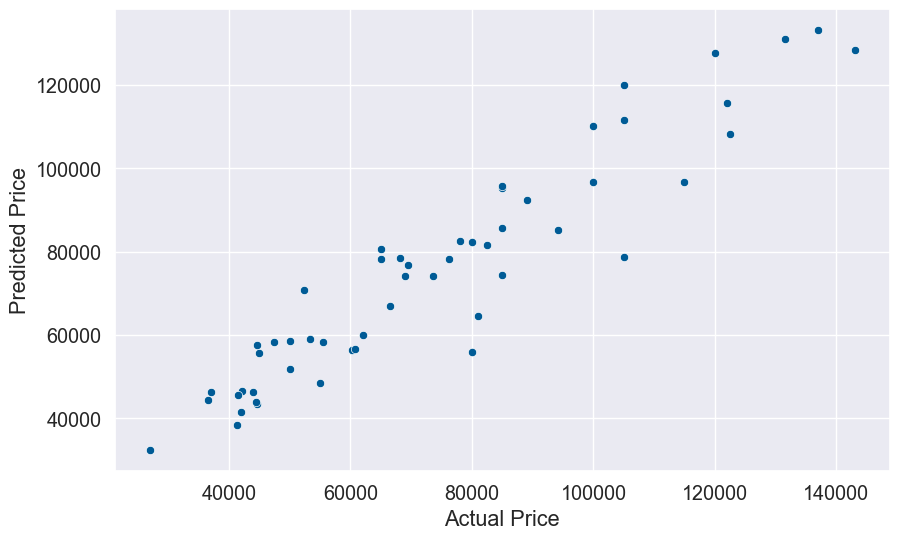

In [283]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

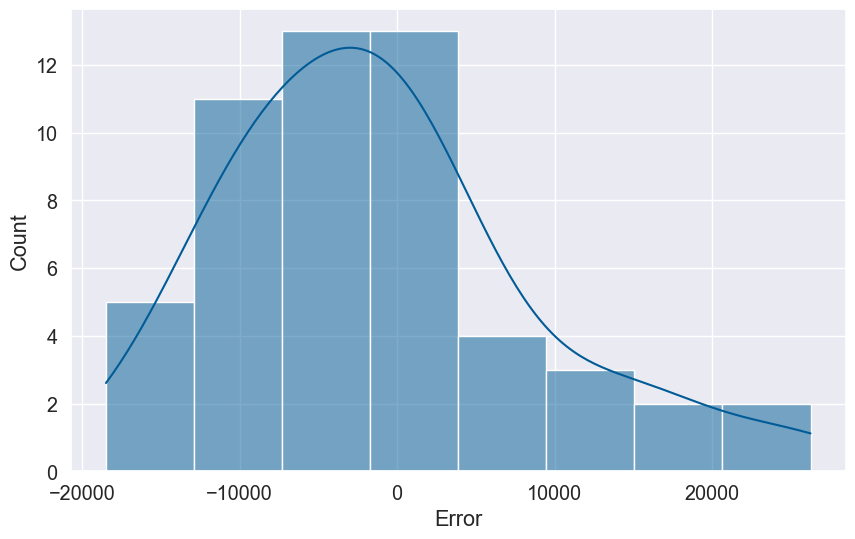

In [284]:
# Distribution of error
plt.figure(figsize = (10, 6))
sns.histplot(y_test - final_predictions, color = '#005b96', kde= True)
plt.xlabel('Error');

In [286]:
dump(models["catboost"],"Catboost.joblib")
dump(models["lightgbm"],"Lightgbm.joblib")
model.save("ANN.keras")

['Lightgbm.joblib']

In [289]:
df

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,0 GB,Casual,1 year,No,No,135990,3 stars,0,0
819,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,0 GB,Casual,1 year,No,No,144990,3 stars,0,0
820,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,4 GB,Casual,1 year,No,No,149990,3 stars,0,0
821,ASUS,AMD,Ryzen 9,Not Available,4 GB,DDR4,1024 GB,0 GB,Windows,64-bit,4 GB,Casual,1 year,No,No,142990,3 stars,0,0
